In [2]:
import numpy as np


def human_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'.rstrip('0').rstrip('.')
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return str(int(x))

# Formatter function to map days → total_edges (in billions)
def billions_formatter(x, pos):
    e = np.interp(x, step_labels_days, total_edges)
    return f"{e / 1_000_000_000:.2f}B"

def compute_mean_std(data):
    data = np.array(data)
    return data.mean(axis=1), data.std(axis=1)

In [3]:
# Focused visualization of Temporal Walk Benchmark results
import pickle
import matplotlib.pyplot as plt

results_dir = 'results/'

# Load the benchmark results
def load_results():
    cpu_results = {
        "edges": pickle.load(open(f"{results_dir}/result_edges_CPU.pkl", "rb")),
        "walks": pickle.load(open(f"{results_dir}/result_walks_CPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open(f"{results_dir}/result_max_walk_lens_CPU.pkl", "rb")),
        "incremental": pickle.load(open(f"{results_dir}/result_incremental_sliding_CPU.pkl", "rb"))
    }
    
    gpu_results = {
        "edges": pickle.load(open(f"{results_dir}/result_edges_GPU.pkl", "rb")),
        "walks": pickle.load(open(f"{results_dir}/result_walks_GPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open(f"{results_dir}/result_max_walk_lens_GPU.pkl", "rb")),
        "incremental": pickle.load(open(f"{results_dir}/result_incremental_sliding_GPU.pkl", "rb"))
    }

    raphtory_results = {
        "edges": pickle.load(open(f"{results_dir}/result_edges_raphtory.pkl", "rb")),
        "incremental": pickle.load(open(f"{results_dir}/result_incremental_raphtory.pkl", "rb"))
    }
    
    return cpu_results, gpu_results, raphtory_results

# Define edge and walk counts from the benchmark
edge_counts = [
    10_000, 50_000, 100_000, 500_000, 1_000_000, 2_000_000,
    5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000,
    50_000_000, 60_000_000
]

walk_counts = [
    10_000, 50_000, 100_000, 200_000, 500_000,
    1_000_000, 2_000_000, 5_000_000, 10_000_000
]

walk_lengths = list(range(10, 310, 10))

# Load results
cpu_results, gpu_results, raphtory_results = load_results()

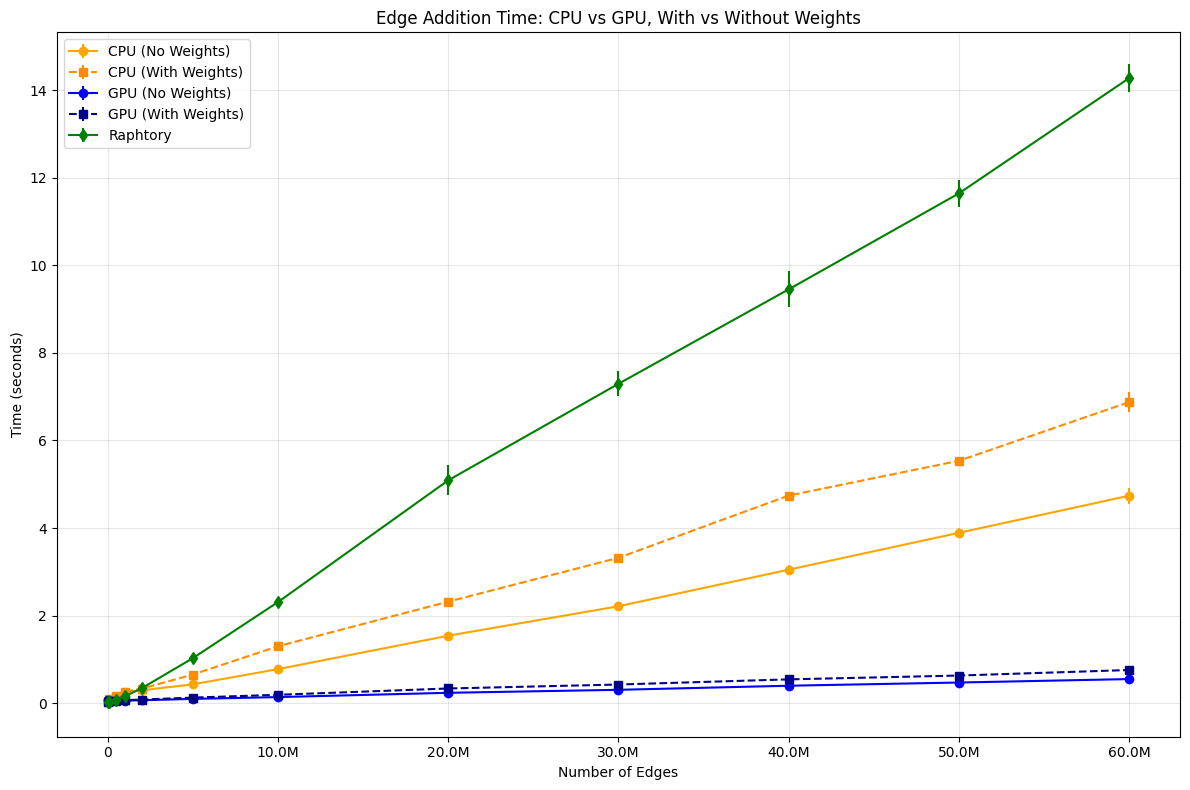

In [4]:
from matplotlib import ticker

cpu_mean_wo, cpu_std_wo = compute_mean_std(cpu_results["edges"]["edge_addition_time_without_weights"])
cpu_mean_w, cpu_std_w = compute_mean_std(cpu_results["edges"]["edge_addition_time_with_weights"])

gpu_mean_wo, gpu_std_wo = compute_mean_std(gpu_results["edges"]["edge_addition_time_without_weights"])
gpu_mean_w, gpu_std_w = compute_mean_std(gpu_results["edges"]["edge_addition_time_with_weights"])

raphtory_mean, raphtory_std = compute_mean_std(raphtory_results["edges"])  # assume already 1D list or array

# Plot
plt.figure(figsize=(12, 8))

plt.errorbar(edge_counts, cpu_mean_wo, yerr=cpu_std_wo,
             fmt='o-', color='orange', label="CPU (No Weights)")

plt.errorbar(edge_counts, cpu_mean_w, yerr=cpu_std_w,
             fmt='s--', color='darkorange', label="CPU (With Weights)")

plt.errorbar(edge_counts, gpu_mean_wo, yerr=gpu_std_wo,
             fmt='o-', color='blue', label="GPU (No Weights)")

plt.errorbar(edge_counts, gpu_mean_w, yerr=gpu_std_w,
             fmt='s--', color='darkblue', label="GPU (With Weights)")

plt.errorbar(edge_counts, raphtory_mean, yerr=raphtory_std, fmt='d-', color='green', label="Raphtory")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Edges")
plt.ylabel("Time (seconds)")
plt.title("Edge Addition Time: CPU vs GPU, With vs Without Weights")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot1_edge_addition_comparison.png")
plt.show()

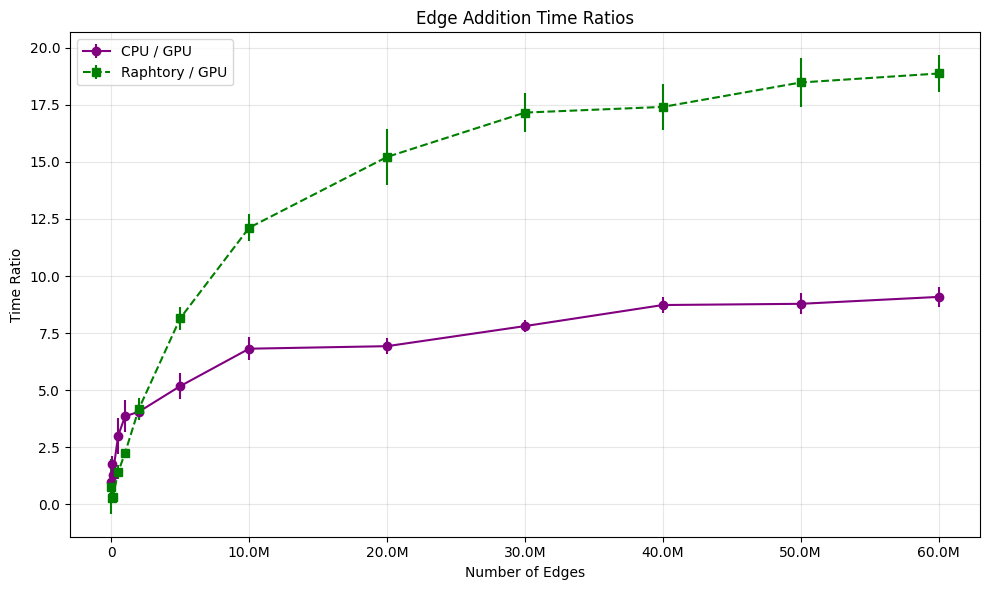

In [5]:
# Means and stds
cpu_mean, cpu_std = compute_mean_std(cpu_results["edges"]["edge_addition_time_with_weights"])
gpu_mean, gpu_std = compute_mean_std(gpu_results["edges"]["edge_addition_time_with_weights"])
raphtory_mean, raphtory_std = compute_mean_std(raphtory_results["edges"])

# Compute ratios and propagated error bars
ratios_cpu_gpu = cpu_mean / gpu_mean
ratios_cpu_gpu_std = ratios_cpu_gpu * np.sqrt((cpu_std / cpu_mean) ** 2 + (gpu_std / gpu_mean) ** 2)

ratios_raphtory_gpu = raphtory_mean / gpu_mean
ratios_raphtory_gpu_std = ratios_raphtory_gpu * np.sqrt((raphtory_std / raphtory_mean) ** 2 + (gpu_std / gpu_mean) ** 2)

# Plot
plt.figure(figsize=(10, 6))

plt.errorbar(edge_counts, ratios_cpu_gpu, yerr=ratios_cpu_gpu_std,
             fmt='o-', color='purple', label='CPU / GPU')

plt.errorbar(edge_counts, ratios_raphtory_gpu, yerr=ratios_raphtory_gpu_std,
             fmt='s--', color='green', label='Raphtory / GPU')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Edges")
plt.ylabel("Time Ratio")
plt.title("Edge Addition Time Ratios")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/ratio_plot1_edge_addition.png")
plt.show()

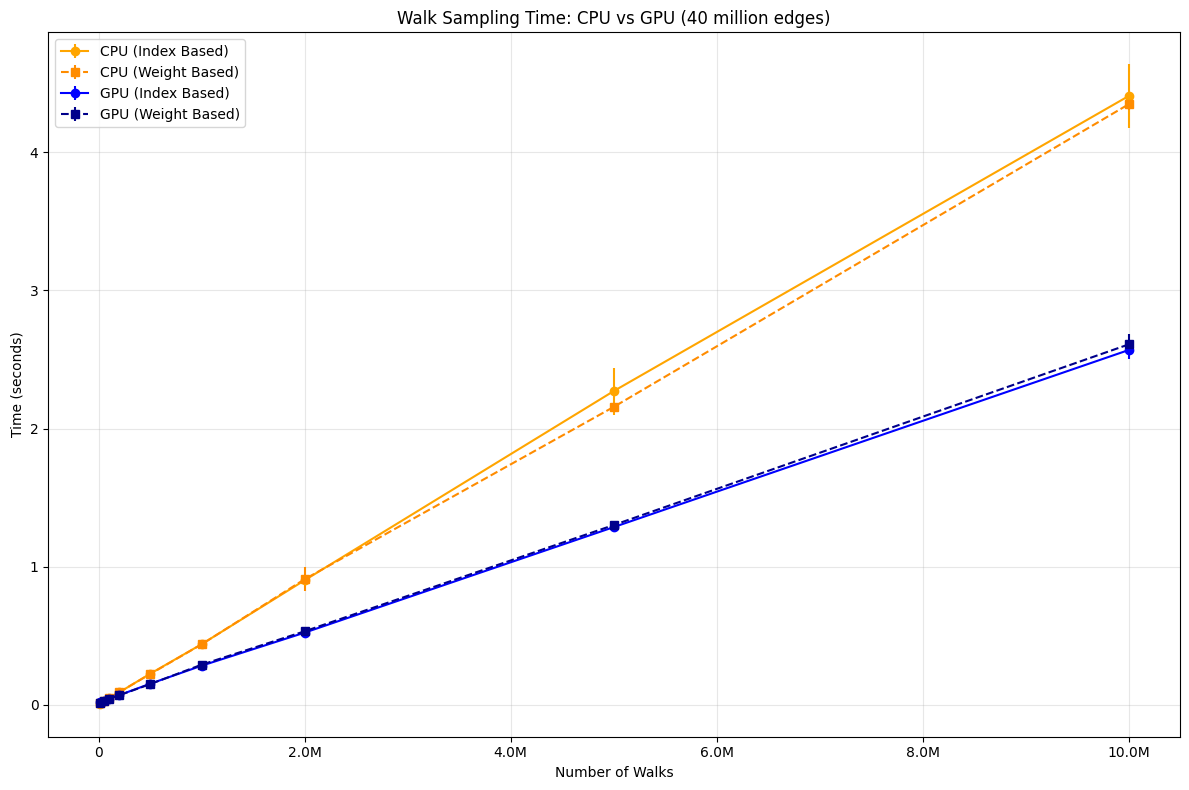

In [6]:
# Compute mean and std for all series
cpu_mean_index, cpu_std_index = compute_mean_std(cpu_results["walks"]["walk_sampling_time_index_based"])
cpu_mean_weight, cpu_std_weight = compute_mean_std(cpu_results["walks"]["walk_sampling_time_weight_based"])
gpu_mean_index, gpu_std_index = compute_mean_std(gpu_results["walks"]["walk_sampling_time_index_based"])
gpu_mean_weight, gpu_std_weight = compute_mean_std(gpu_results["walks"]["walk_sampling_time_weight_based"])

# Plot
plt.figure(figsize=(12, 8))

plt.errorbar(walk_counts, cpu_mean_index, yerr=cpu_std_index,
             fmt='o-', color='orange', label="CPU (Index Based)")

plt.errorbar(walk_counts, cpu_mean_weight, yerr=cpu_std_weight,
             fmt='s--', color='darkorange', label="CPU (Weight Based)")

plt.errorbar(walk_counts, gpu_mean_index, yerr=gpu_std_index,
             fmt='o-', color='blue', label="GPU (Index Based)")

plt.errorbar(walk_counts, gpu_mean_weight, yerr=gpu_std_weight,
             fmt='s--', color='darkblue', label="GPU (Weight Based)")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Walks")
plt.ylabel("Time (seconds)")
plt.title("Walk Sampling Time: CPU vs GPU (40 million edges)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot2_walk_sampling_comparison.png")
plt.show()

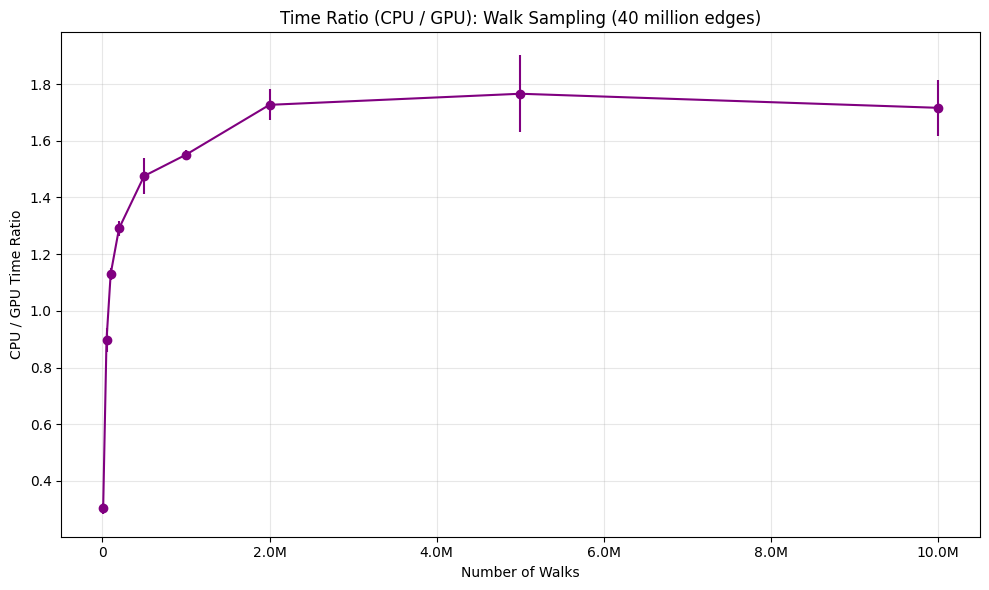

In [7]:
# 1. Extract and compute mean/std
cpu_mean, cpu_std = compute_mean_std(cpu_results["walks"]["walk_sampling_time_index_based"])
gpu_mean, gpu_std = compute_mean_std(gpu_results["walks"]["walk_sampling_time_index_based"])

# 2. Compute ratio and error propagation
ratios = cpu_mean / gpu_mean
ratios_std = ratios * np.sqrt((cpu_std / cpu_mean) ** 2 + (gpu_std / gpu_mean) ** 2)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.errorbar(walk_counts, ratios, yerr=ratios_std, fmt='o-', color='purple')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Number of Walks")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Time Ratio (CPU / GPU): Walk Sampling (40 million edges)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot2_walk_sampling.png")
plt.show()

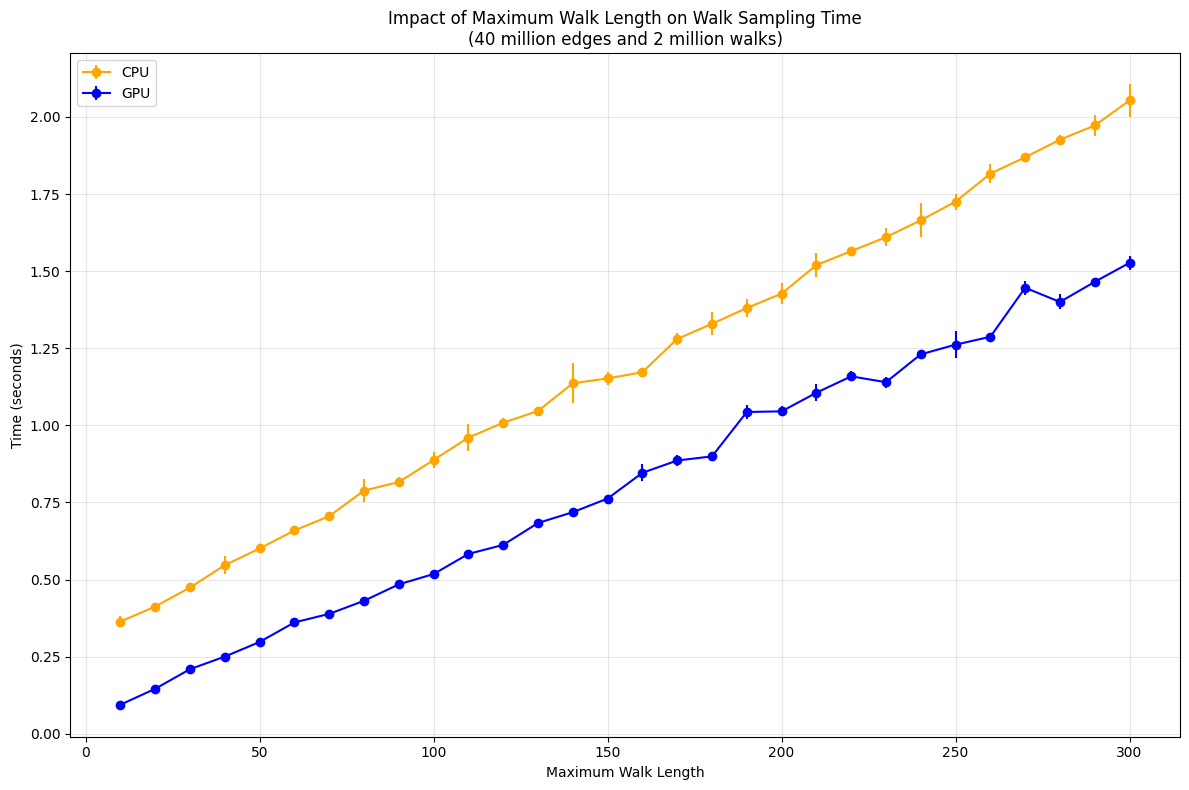

In [8]:
# Compute mean and std for each walk length
cpu_mean, cpu_std = compute_mean_std(cpu_results["max_walk_lens"]["walk_sampling_time"])
gpu_mean, gpu_std = compute_mean_std(gpu_results["max_walk_lens"]["walk_sampling_time"])

# Plot
plt.figure(figsize=(12, 8))

plt.errorbar(walk_lengths, cpu_mean, yerr=cpu_std,
             fmt='o-', color='orange', label="CPU")

plt.errorbar(walk_lengths, gpu_mean, yerr=gpu_std,
             fmt='o-', color='blue', label="GPU")

plt.xlabel("Maximum Walk Length")
plt.ylabel("Time (seconds)")
plt.title("Impact of Maximum Walk Length on Walk Sampling Time\n(40 million edges and 2 million walks)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot3_walk_length_impact.png")
plt.show()

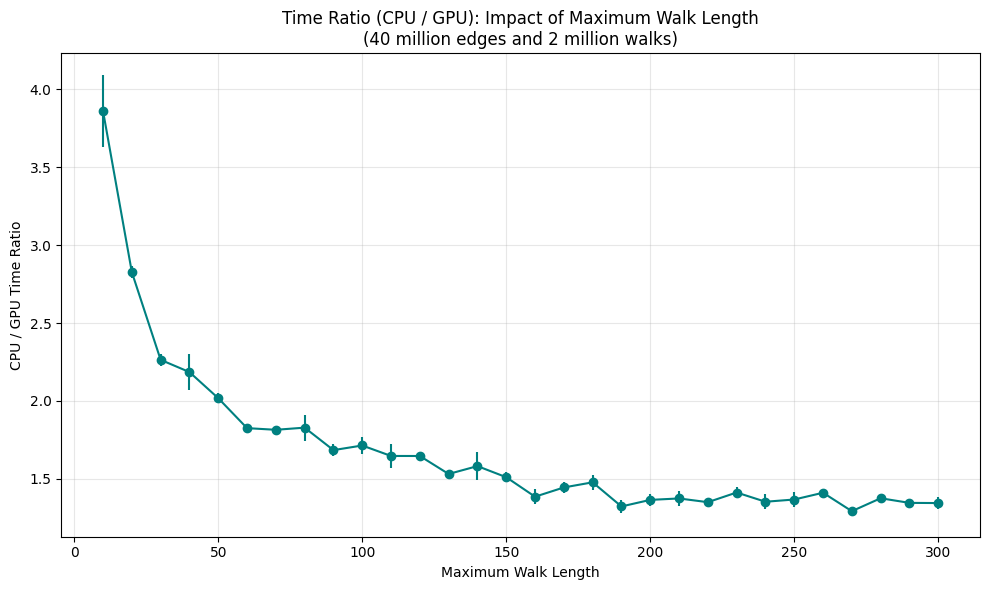

In [9]:
# 1. Compute mean and std
cpu_mean, cpu_std = compute_mean_std(cpu_results["max_walk_lens"]["walk_sampling_time"])
gpu_mean, gpu_std = compute_mean_std(gpu_results["max_walk_lens"]["walk_sampling_time"])

# 2. Compute ratios and propagated error
ratios = cpu_mean / gpu_mean
ratios_std = ratios * np.sqrt((cpu_std / cpu_mean) ** 2 + (gpu_std / gpu_mean) ** 2)

# 3. Plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(walk_lengths, ratios, yerr=ratios_std, fmt='o-', color='teal')

plt.xlabel("Maximum Walk Length")
plt.ylabel("CPU / GPU Time Ratio")
plt.title("Time Ratio (CPU / GPU): Impact of Maximum Walk Length\n(40 million edges and 2 million walks)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/ratio_plot3_walk_length.png")
plt.show()

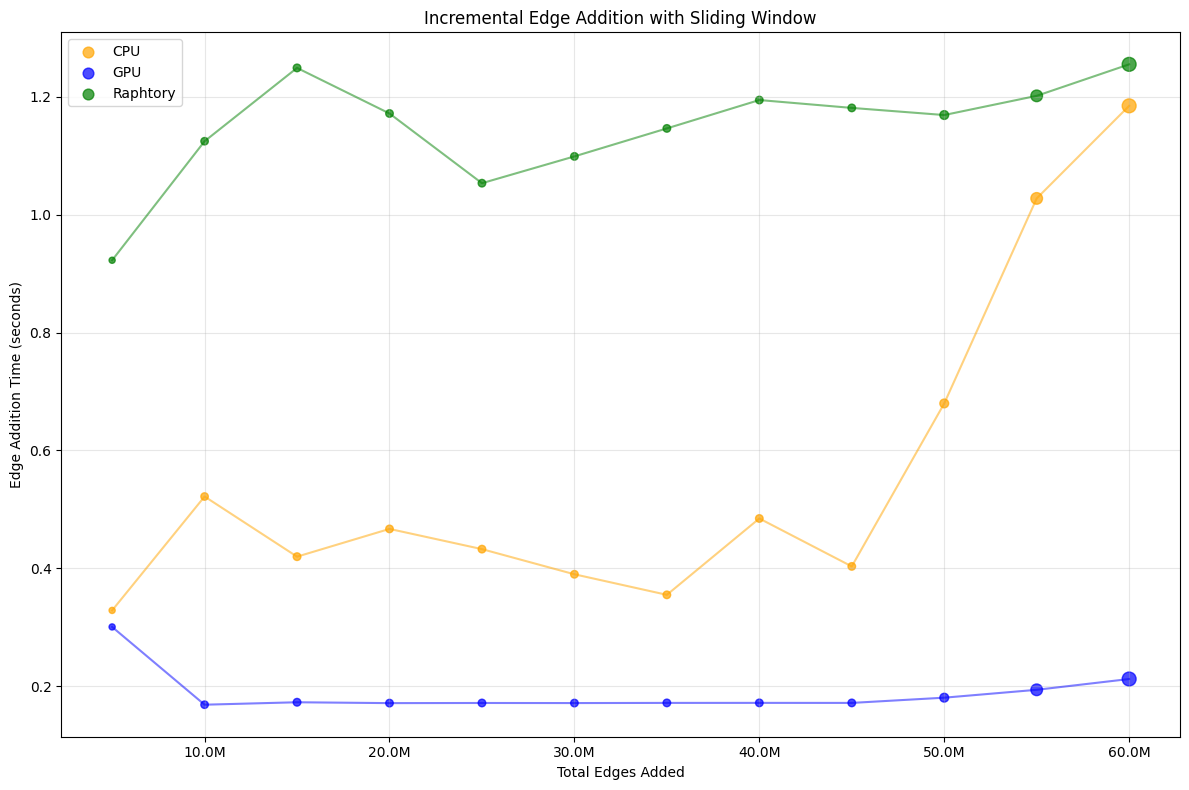

In [10]:
# Plot 4: Incremental Edge Addition with Active Edges
plt.figure(figsize=(12, 8))

# Create scatter plots with size indicating active edges
cpu_total_edges = cpu_results["incremental"]["total_edges"]
cpu_active_edges = cpu_results["incremental"]["active_edges"]
cpu_edge_addition_time = cpu_results["incremental"]["edge_addition_time"]

gpu_total_edges = gpu_results["incremental"]["total_edges"]
gpu_active_edges = gpu_results["incremental"]["active_edges"]
gpu_edge_addition_time = gpu_results["incremental"]["edge_addition_time"]
raphtory_edge_addition_time = raphtory_results["incremental"]

# Calculate normalized size for scatter points
max_active = max(max(cpu_active_edges), max(gpu_active_edges))
cpu_sizes = [100 * active / max_active for active in cpu_active_edges]
gpu_sizes = [100 * active / max_active for active in gpu_active_edges]

# Plot the data
sc_cpu = plt.scatter(cpu_total_edges, cpu_edge_addition_time,
                     s=cpu_sizes, c='orange', alpha=0.7, label="CPU")
sc_gpu = plt.scatter(gpu_total_edges, gpu_edge_addition_time,
                     s=gpu_sizes, c='blue', alpha=0.7, label="GPU")
sc_raphtory = plt.scatter(cpu_total_edges, raphtory_edge_addition_time,
                     s=cpu_sizes, c='green', alpha=0.7, label="Raphtory")

# Add lines to connect points
plt.plot(cpu_total_edges, cpu_edge_addition_time, 'orange', alpha=0.5)
plt.plot(gpu_total_edges, gpu_edge_addition_time, 'blue', alpha=0.5)
plt.plot(cpu_total_edges, raphtory_edge_addition_time, 'green', alpha=0.5)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("Edge Addition Time (seconds)")
plt.title("Incremental Edge Addition with Sliding Window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot4_incremental_edge_addition.png")
plt.show()

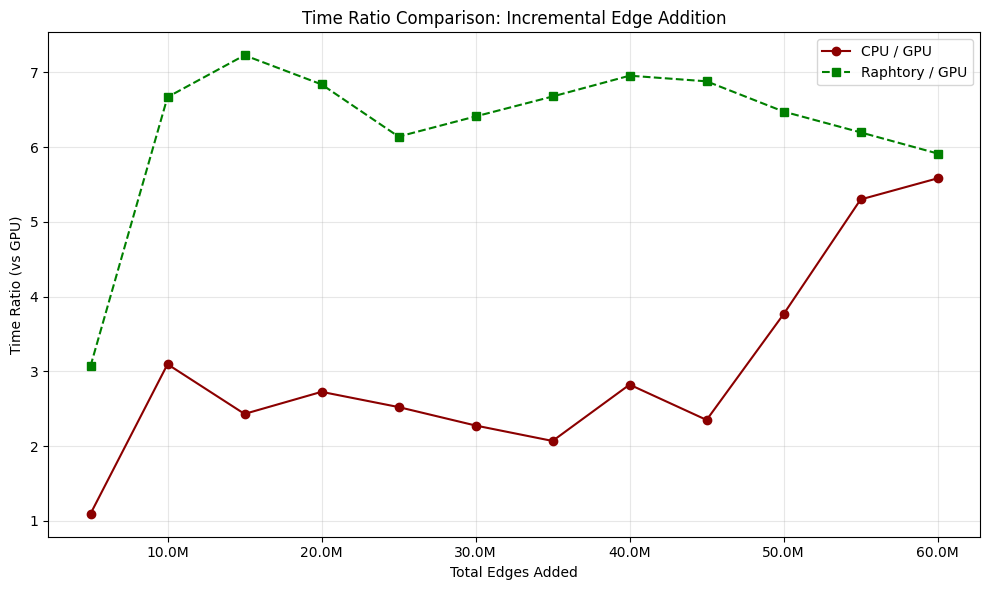

In [11]:
# CPU and GPU incremental times
cpu_times = cpu_results["incremental"]["edge_addition_time"]
gpu_times = gpu_results["incremental"]["edge_addition_time"]
raphtory_times = raphtory_results["incremental"]

# Compute ratios
ratios_cpu_gpu = [c / g if g != 0 else float('inf') for c, g in zip(cpu_times, gpu_times)]
ratios_raphtory_gpu = [r / g if g != 0 else float('inf') for r, g in zip(raphtory_times, gpu_times)]

# X-axis: total edges
total_edges = cpu_results["incremental"]["total_edges"]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(total_edges, ratios_cpu_gpu, marker='o', linestyle='-', color='darkred', label="CPU / GPU")
plt.plot(total_edges, ratios_raphtory_gpu, marker='s', linestyle='--', color='green', label="Raphtory / GPU")

# Format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("Time Ratio (vs GPU)")
plt.title("Time Ratio Comparison: Incremental Edge Addition")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/ratio_plot4_incremental_edge_addition.png")
plt.show()

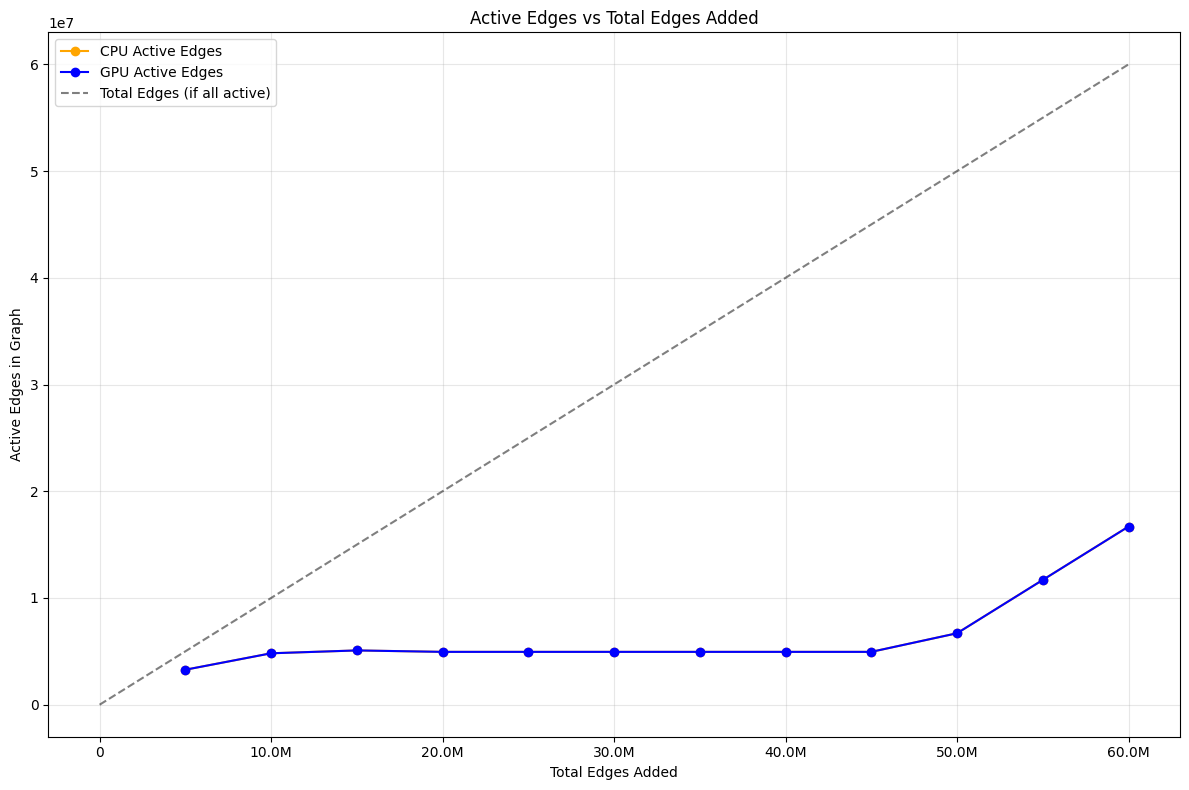

In [12]:
plt.figure(figsize=(12, 8))

# Plot active edges vs total edges
plt.plot(cpu_total_edges, cpu_active_edges, 'o-', color='orange', label="CPU Active Edges")
plt.plot(gpu_total_edges, gpu_active_edges, 'o-', color='blue', label="GPU Active Edges")

# Add a reference line showing total edges (y=x line)
max_total = max(max(cpu_total_edges), max(gpu_total_edges))
plt.plot([0, max_total], [0, max_total], 'k--', alpha=0.5, label="Total Edges (if all active)")

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(human_format))
plt.xlabel("Total Edges Added")
plt.ylabel("Active Edges in Graph")
plt.title("Active Edges vs Total Edges Added")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot5_total_vs_active_edges.png")
plt.show()

In [13]:
alibaba_data_gpu = pickle.load(open(f"{results_dir}/result_alibaba_streaming_GPU.pkl", "rb"))
alibaba_data_cpu = pickle.load(open(f"{results_dir}/result_alibaba_streaming_CPU.pkl", "rb"))

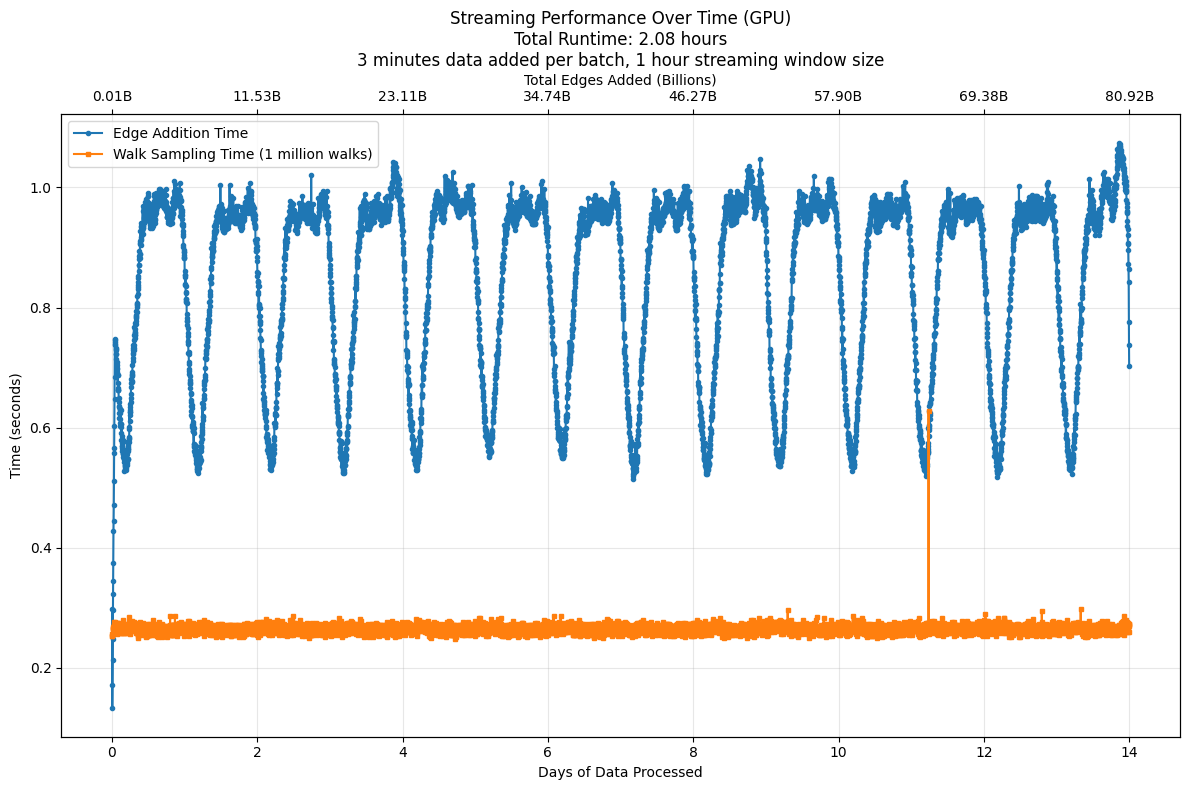

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Primary data
edge_addition_time = alibaba_data_gpu['edge_addition_time']
walk_sampling_time = alibaba_data_gpu['walk_sampling_time']
total_edges = alibaba_data_gpu['total_edges']

# Compute total runtime in hours
total_time = np.sum(edge_addition_time) + np.sum(walk_sampling_time)
total_time_hours = total_time / 3600  # convert seconds to hours

# X-axis labels
minutes_per_step = 3
steps = list(range(1, len(edge_addition_time) + 1))
step_labels_minutes = [s * minutes_per_step for s in steps]
step_labels_days = [m / 1440 for m in step_labels_minutes]  # 1440 mins/day

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot edge and walk times over days
ax1.plot(step_labels_days, edge_addition_time, label='Edge Addition Time', marker='o', markersize=3, linestyle='-')
ax1.plot(step_labels_days, walk_sampling_time, label='Walk Sampling Time (1 million walks)', marker='s', markersize=3, linestyle='-')

ax1.set_xlabel("Days of Data Processed")
ax1.set_ylabel("Time (seconds)")
ax1.set_title(f"Streaming Performance Over Time (GPU)\nTotal Runtime: {total_time_hours:.2f} hours\n3 minutes data added per batch, 1 hour streaming window size")
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- Secondary X-axis: Total edges added in billions ---
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))
ax2.set_xlabel("Total Edges Added (Billions)")

plt.tight_layout()
plt.savefig("plots/alibaba_gpu.png")
plt.show()

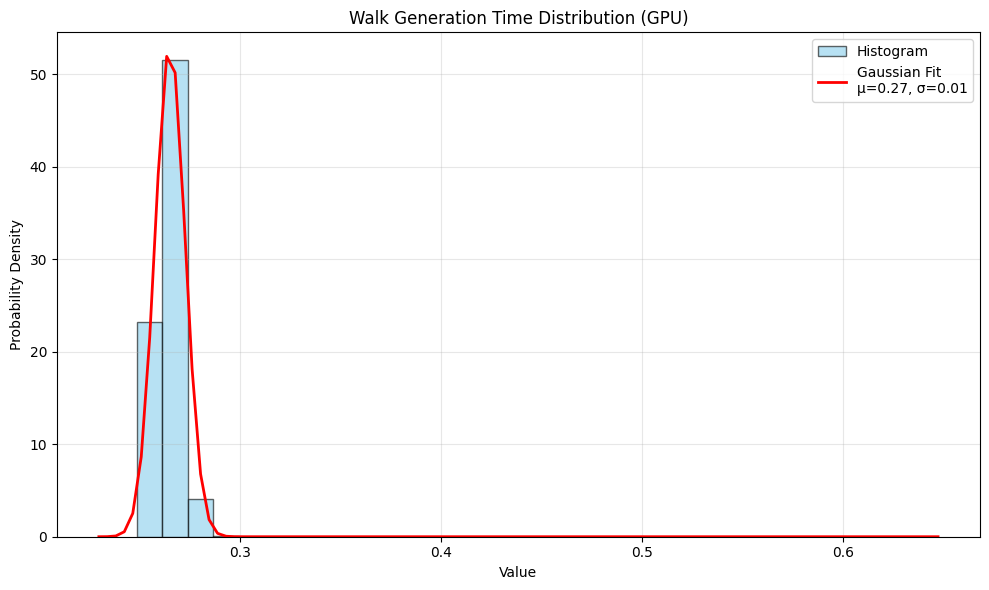

In [15]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

mu, std = norm.fit(alibaba_data_gpu['walk_sampling_time'])

# Plot histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(alibaba_data_gpu['walk_sampling_time'], bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={std:.2f}')

plt.title('Walk Generation Time Distribution (GPU)')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('plots/gpu_walk_time_distribution.png')
plt.show()

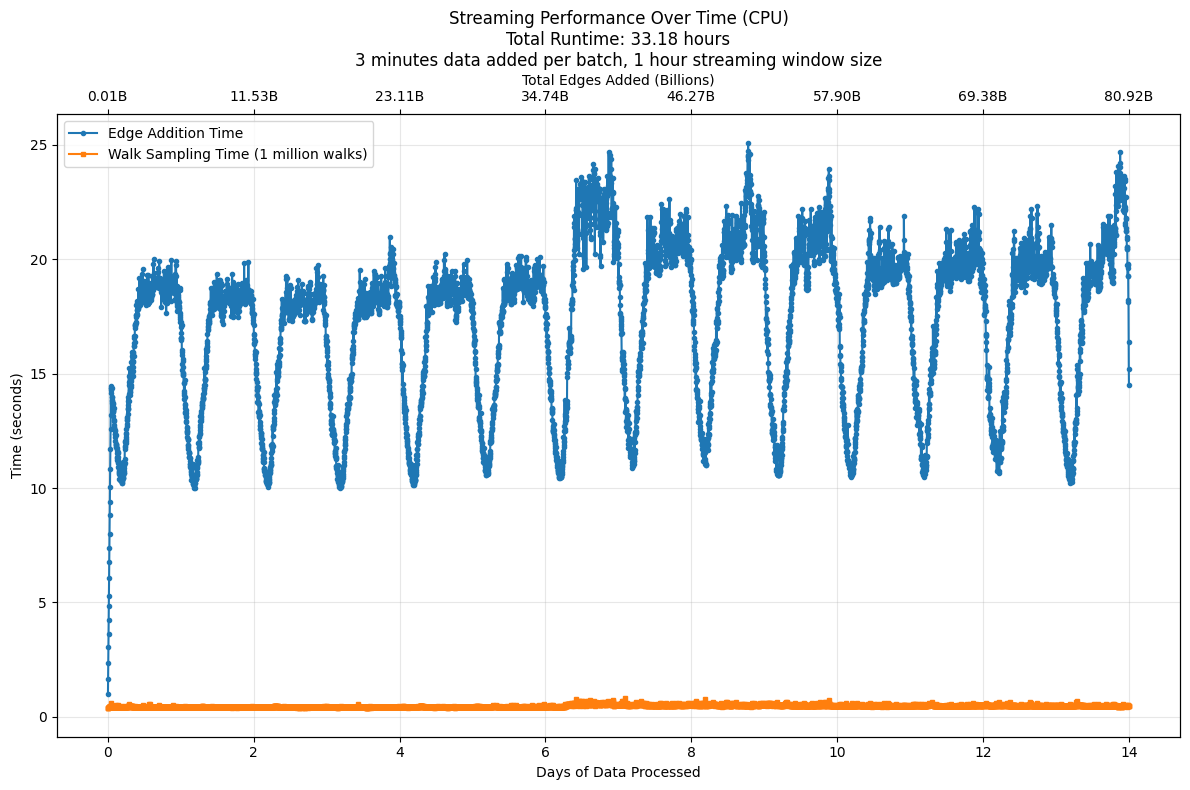

In [16]:
# Primary data
edge_addition_time = alibaba_data_cpu['edge_addition_time']
walk_sampling_time = alibaba_data_cpu['walk_sampling_time']
total_edges = alibaba_data_cpu['total_edges']

# Compute total runtime in hours
total_time = np.sum(edge_addition_time) + np.sum(walk_sampling_time)
total_time_hours = total_time / 3600  # convert seconds to hours

# X-axis labels
minutes_per_step = 3
steps = list(range(1, len(edge_addition_time) + 1))
step_labels_minutes = [s * minutes_per_step for s in steps]
step_labels_days = [m / 1440 for m in step_labels_minutes]  # 1440 mins/day

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot edge and walk times over days
ax1.plot(step_labels_days, edge_addition_time, label='Edge Addition Time', marker='o', markersize=3, linestyle='-')
ax1.plot(step_labels_days, walk_sampling_time, label='Walk Sampling Time (1 million walks)', marker='s', markersize=3, linestyle='-')

ax1.set_xlabel("Days of Data Processed")
ax1.set_ylabel("Time (seconds)")
ax1.set_title(f"Streaming Performance Over Time (CPU)\nTotal Runtime: {total_time_hours:.2f} hours\n3 minutes data added per batch, 1 hour streaming window size")
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- Secondary X-axis: Total edges added in billions ---
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))
ax2.set_xlabel("Total Edges Added (Billions)")

plt.tight_layout()
plt.savefig("plots/alibaba_cpu.png")
plt.show()

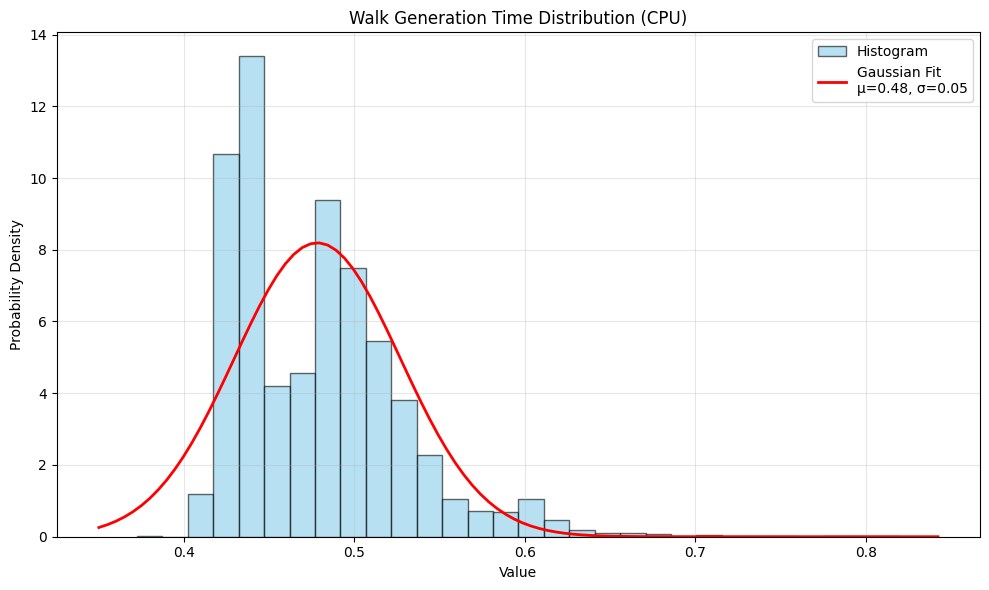

In [17]:
mu, std = norm.fit(alibaba_data_cpu['walk_sampling_time'])

# Plot histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(alibaba_data_cpu['walk_sampling_time'], bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label=f'Gaussian Fit\nμ={mu:.2f}, σ={std:.2f}')

plt.title('Walk Generation Time Distribution (CPU)')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('plots/cpu_walk_time_distribution.png')
plt.show()

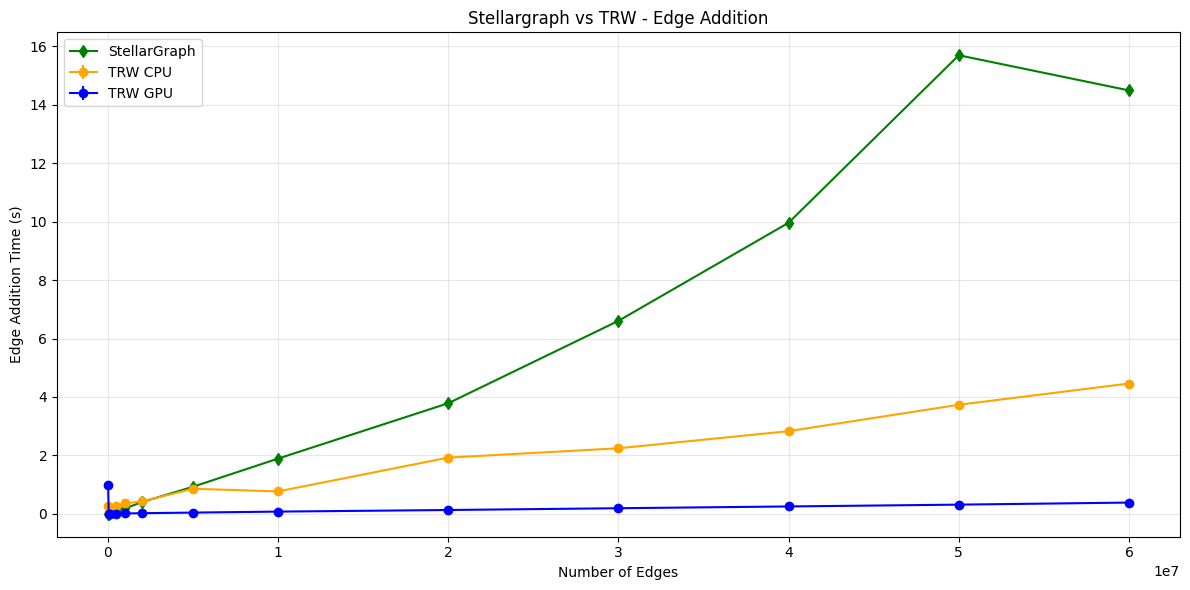

In [35]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# Load results
with open("results/stellargraph_results.pkl", "rb") as f:
    results = pickle.load(f)

def compute_mean_std(data):
    data = np.array(data)
    return data.mean(axis=1), data.std(axis=1)

# Edge counts for edge addition
edge_counts = [
    10_000, 50_000, 100_000, 500_000, 1_000_000, 2_000_000,
    5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000,
    50_000_000, 60_000_000
]

plt.figure(figsize=(12, 6))

# TRW CPU (Index-Based only = no weights)
cpu_index, cpu_index_std = compute_mean_std(results['edge_addition_trw_cpu']['edge_addition_time_without_weights'])

# TRW GPU (Index-Based only = no weights)
gpu_index, gpu_index_std = compute_mean_std(results['edge_addition_trw_gpu']['edge_addition_time_without_weights'])

# StellarGraph
stellargraph_mean, _ = compute_mean_std(results['edge_addition_stellargraph'])

plt.errorbar(edge_counts, cpu_index, yerr=cpu_index_std, label="TRW CPU", fmt='o-', color='orange')
plt.errorbar(edge_counts, gpu_index, yerr=gpu_index_std, label="TRW GPU", fmt='o-', color='blue')
plt.plot(edge_counts, stellargraph_mean, label="StellarGraph", marker='d', linestyle='-', color='green')

plt.xlabel("Number of Edges")
plt.ylabel("Edge Addition Time (s)")
plt.title("Stellargraph vs TRW - Edge Addition")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plots/plot_edge_addition_times_stellargraph_vs_trw.png")
plt.show()

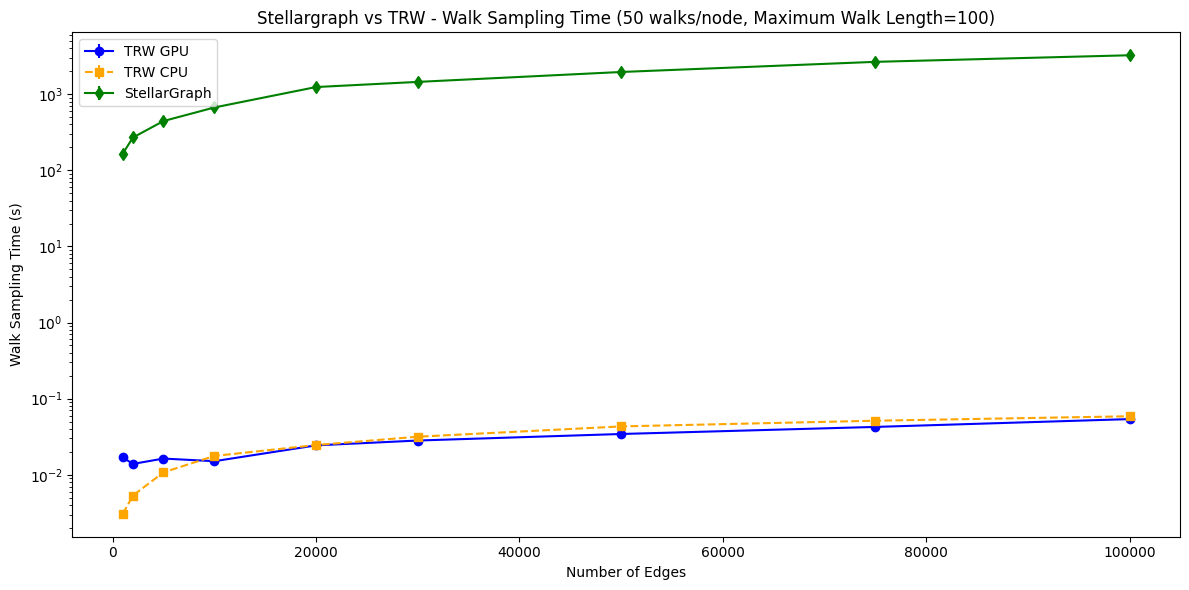

In [36]:
# Edge sizes used in walk sampling
edge_sizes = [1_000, 2_000, 5_000, 10_000, 20_000, 30_000, 50_000, 75_000, 100_000]

# TRW GPU (Index-Based)
gpu_walk_index, gpu_walk_index_std = compute_mean_std(
    results['walk_sampling_vs_edge_size_trw_gpu']['walk_sampling_time_index_based']
)

# TRW CPU (Index-Based)
cpu_walk_index, cpu_walk_index_std = compute_mean_std(
    results['walk_sampling_vs_edge_size_trw_cpu']['walk_sampling_time_index_based']
)

# StellarGraph
stellar_walk, stellar_walk_std = compute_mean_std(
    results['walk_sampling_vs_edge_size_stellargraph']['walk_sampling_time']
)

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(edge_sizes, gpu_walk_index, yerr=gpu_walk_index_std, label="TRW GPU", fmt='o-', color='blue')
plt.errorbar(edge_sizes, cpu_walk_index, yerr=cpu_walk_index_std, label="TRW CPU", fmt='s--', color='orange')
plt.errorbar(edge_sizes, stellar_walk, yerr=stellar_walk_std, label="StellarGraph", fmt='d-', color='green')

plt.xlabel("Number of Edges")
plt.ylabel("Walk Sampling Time (s)")
plt.yscale('log')
plt.title("Stellargraph vs TRW - Walk Sampling Time (50 walks/node, Maximum Walk Length=100)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot_walk_sampling_times_stellargraph_vs_trw.png")
plt.show()

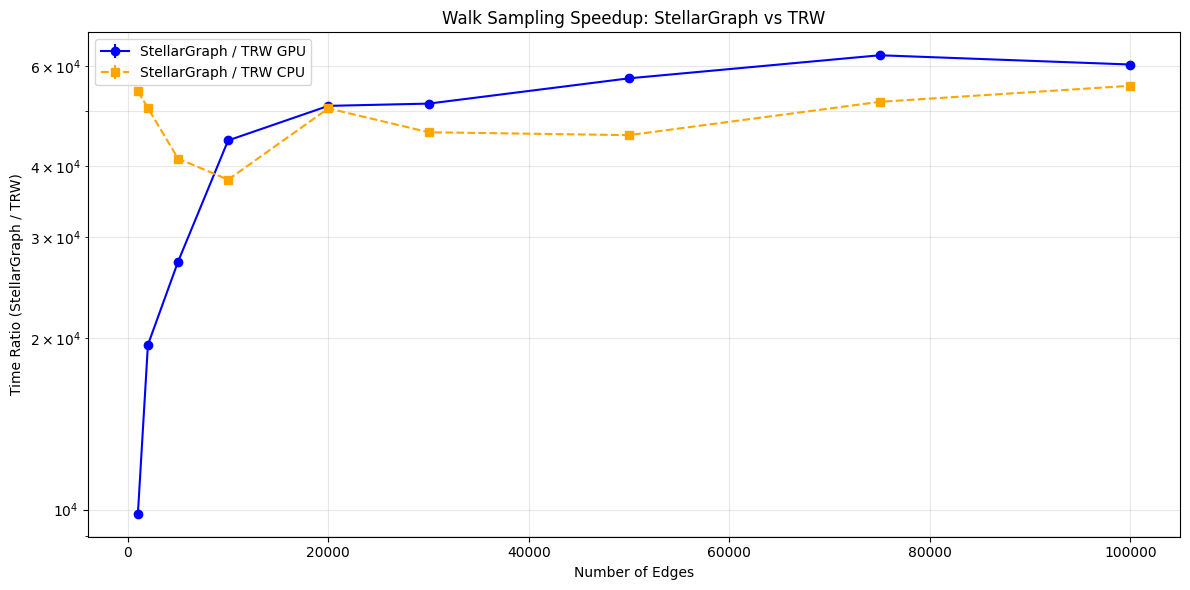

In [37]:
# Calculate mean and std again to ensure alignment
stellar_mean, stellar_std = compute_mean_std(results['walk_sampling_vs_edge_size_stellargraph']['walk_sampling_time'])
gpu_mean, gpu_std = compute_mean_std(results['walk_sampling_vs_edge_size_trw_gpu']['walk_sampling_time_index_based'])
cpu_mean, cpu_std = compute_mean_std(results['walk_sampling_vs_edge_size_trw_cpu']['walk_sampling_time_index_based'])

# Compute speedup ratios and propagated std (error propagation for division)
ratio_gpu = stellar_mean / gpu_mean
ratio_gpu_std = ratio_gpu * np.sqrt((stellar_std / stellar_mean) ** 2 + (gpu_std / gpu_mean) ** 2)

ratio_cpu = stellar_mean / cpu_mean
ratio_cpu_std = ratio_cpu * np.sqrt((stellar_std / stellar_mean) ** 2 + (cpu_std / cpu_mean) ** 2)

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(edge_sizes, ratio_gpu, yerr=ratio_gpu_std, fmt='o-', color='blue', label='StellarGraph / TRW GPU')
plt.errorbar(edge_sizes, ratio_cpu, yerr=ratio_cpu_std, fmt='s--', color='orange', label='StellarGraph / TRW CPU')

plt.xlabel("Number of Edges")
plt.ylabel("Time Ratio (StellarGraph / TRW)")
plt.yscale('log')  # Log scale to show multiplicative gain
plt.title("Walk Sampling Speedup: StellarGraph vs TRW")
plt.grid(True, alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot_walk_sampling_ratios_stellargraph_vs_trw.png")
plt.show()